### Imports

In [1]:
import sys
mypath = "/home/basia/Documents/spectroscopy/magnetstein"
sys.path.insert(0, mypath)

In [2]:
import numpy as np
import pandas as pd
import os
from masserstein import NMRSpectrum, estimate_proportions
import matplotlib.pyplot as plt
import pulp
import pickle

### Data

In [3]:
experiment_name = 'PMG 284 monitoring'

In [4]:
mixture_paths = {'Saccharose hydrolysis': '../data/saccharose_hydrolysis/preprocessed_mixture.csv',
                'PMG 284 monitoring': '../data/PMG_284/preprocessed_mixture.csv',
                'PMG 287 monitoring': '../data/PMG_287/preprocessed_mixture.csv'
                }

reagents_paths = {'Saccharose hydrolysis': ['../data/saccharose_hydrolysis/preprocessed_saccharose.csv', 
                                            '../data/saccharose_hydrolysis/preprocessed_alpha_glucose.csv',
                                            '../data/saccharose_hydrolysis/preprocessed_beta_glucose.csv',
                                            '../data/saccharose_hydrolysis/preprocessed_fructose.csv'],
                'PMG 284 monitoring': ['../data/PMG_284/preprocessed_substrate0.csv',
                                      '../data/PMG_284/preprocessed_substrate1.csv',
                                      '../data/PMG_284/preprocessed_product.csv'],
                'PMG 287 monitoring': ['../data/PMG_287/preprocessed_substrate0.csv',
                                      '../data/PMG_287/preprocessed_substrate1.csv',
                                      '../data/PMG_287/preprocessed_product.csv']}

mixture_separators = {'Saccharose hydrolysis': '\t',
                'PMG 284 monitoring': '\t',
                'PMG 287 monitoring': '\t'
                }

reagents_separators = {'Saccharose hydrolysis': '\t',
                'PMG 284 monitoring': '\t',
                'PMG 287 monitoring': '\t'
                }

results_paths = {'Saccharose hydrolysis': '../results/saccharose_hydrolysis/glucose_split/',
                'PMG 284 monitoring': '../results/PMG_284/',
                'PMG 287 monitoring': '../results/PMG_287/comparing_with_first/'}

#### Mixture in time

In [5]:
mixture_time_data = pd.read_csv(mixture_paths[experiment_name], sep = mixture_separators[experiment_name])
if experiment_name == 'Saccharose hydrolysis':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    every_10th = mixture_time_data = mixture_time_data.iloc[:,:-1].iloc[:,1:].iloc[:,::10]
    mixture_time_data = pd.concat((ppm, every_10th), axis=1)
elif experiment_name == 'PMG 284 monitoring':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    every_10th = mixture_time_data = mixture_time_data.iloc[:,:-1].iloc[:,1:].iloc[:,::10]
    mixture_time_data = pd.concat((ppm, every_10th), axis=1)
elif experiment_name == 'PMG 287 monitoring':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    every_10th = mixture_time_data = mixture_time_data.iloc[:,:-1].iloc[:,1:].iloc[:,::10]
    mixture_time_data = pd.concat((ppm, every_10th), axis=1)

In [6]:
names = ['ppm'] + ['t' + str(nb) for nb in range(1, mixture_time_data.shape[1])]

In [7]:
mixture_time_data.columns = names

In [8]:
def load_spectrum(mixture_time_data, moment_of_time):
    ppm = mixture_time_data['ppm']
    intensity = mixture_time_data['t'+str(moment_of_time)]
    sp = NMRSpectrum(confs = list(zip(ppm, intensity)))
    sp.trim_negative_intensities()
    sp.normalize()
    return sp

#### Reagents

In [9]:
reagents_spectra = []
for reagent in reagents_paths[experiment_name]:
    reag = pd.read_csv(reagent, sep=reagents_separators[experiment_name], header=None).iloc[:,:2]
    reagents_spectra.append(reag)

In [10]:
reagents_spectra2 = []
for reag in reagents_spectra:
    ppm = reag.iloc[:,0]
    ints = reag.iloc[:,1]
    sp = NMRSpectrum(confs = list(zip(ppm, ints)))
    reagents_spectra2.append(sp)
reagents_spectra = reagents_spectra2
del(reagents_spectra2)

In [11]:
for sp in reagents_spectra:
    sp.trim_negative_intensities()
    sp.normalize()

In [13]:
%matplotlib notebook

In [14]:
reagents_spectra

<IPython.core.display.Javascript object>


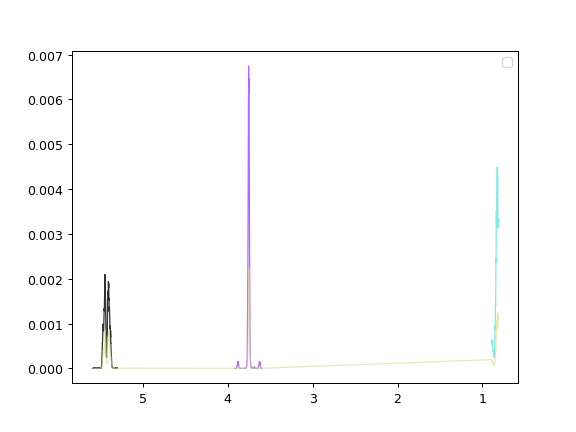

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [15]:
plt.gca().invert_xaxis()
NMRSpectrum.plot_all(reagents_spectra + [load_spectrum(mixture_time_data, 100)], profile=True)

### Estimation

In [16]:
kappa = 0.1
kappa_th = 0.25

In [17]:
proportions_in_times = []
noise_proportions_in_times = []
noise = []
noise_in_components = []

for i in range(1, mixture_time_data.shape[1]):
    print('This is timepoint '+str(i)+'.\n')
    mix = load_spectrum(mixture_time_data, i)
    mix.trim_negative_intensities()
    mix.normalize()
    estimation = estimate_proportions(mix, reagents_spectra, what_to_compare='area', 
                                      solver=pulp.GUROBI(msg=False),
                                     MTD=kappa, MTD_th=kappa_th)
    proportions_in_times.append(estimation['proportions'])
    noise_proportions_in_times.append(estimation['proportion_of_noise_in_components'])
    noise.append(estimation['noise'])
    noise_in_components.append(estimation['noise_in_components'])
    if i>1:
        assert estimation['common_horizontal_axis'] == common_horizontal_axis
    common_horizontal_axis = estimation['common_horizontal_axis']
    
    print('Proportions:\n')
    print(estimation['proportions'])
    print('\n')
    print('Proportion_of_noise_in_components:\n')
    print(estimation['proportion_of_noise_in_components'])
    print('\n')

This is timepoint 1.

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13


/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Proportions:

[0.4549870262008286, 0.5321983425980619, 0.009084698463181976]


Proportion_of_noise_in_components:

0.0


This is timepoint 2.

Proportions:

[0.5942743560311617, 0.38743802540411915, 0.009756201317131775]


Proportion_of_noise_in_components:

0.0


This is timepoint 3.

Proportions:

[0.5928832431043235, 0.38562275747210223, 0.014030961897797489]


Proportion_of_noise_in_components:

0.0


This is timepoint 4.

Proportions:

[0.586937452989742, 0.38713123664979493, 0.017765140649107114]


Proportion_of_noise_in_components:

0.0


This is timepoint 5.

Proportions:

[0.5866062857338467, 0.3892129757991568, 0.02037280498756867]


Proportion_of_noise_in_components:

0.0


This is timepoint 6.

Proportions:

[0.5843182952819191, 0.3882986671473407, 0.02283236414221809]


Proportion_of_noise_in_components:

0.0


This is timepoint 7.

Proportions:

[0.5828733503647605, 0.38833632973935167, 0.02503144369200247]


Proportion_of_noise_in_components:

0.0


This is timepoint 8.


Proportions:

[0.4846540819299021, 0.3678448126026925, 0.14637392263591972]


Proportion_of_noise_in_components:

0.0


This is timepoint 60.

Proportions:

[0.4811952904300149, 0.3672429825410275, 0.15019701094699456]


Proportion_of_noise_in_components:

0.0


This is timepoint 61.

Proportions:

[0.4765214524163299, 0.3650863003811088, 0.15699883453481644]


Proportion_of_noise_in_components:

0.0


This is timepoint 62.

Proportions:

[0.47448037016513145, 0.36628770298958435, 0.15736771455659357]


Proportion_of_noise_in_components:

0.0


This is timepoint 63.

Proportions:

[0.4699109155298448, 0.36356638838985655, 0.16616872118344042]


Proportion_of_noise_in_components:

0.0


This is timepoint 64.

Proportions:

[0.4677422010540982, 0.3622960808163325, 0.16872760020745095]


Proportion_of_noise_in_components:

0.0


This is timepoint 65.

Proportions:

[0.46492279544678816, 0.3631731264180594, 0.17126434734354437]


Proportion_of_noise_in_components:

0.0


This is timepoint 

In [18]:
len(proportions_in_times)

100

<IPython.core.display.Javascript object>


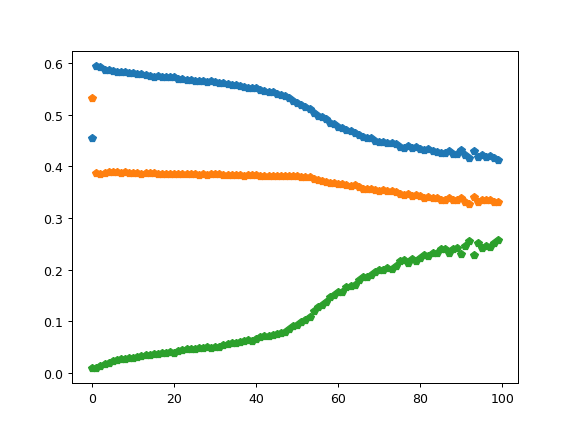

In [19]:
plt.plot(range(len(proportions_in_times)), [prop[0] for prop in proportions_in_times], 'p')
plt.plot(range(len(proportions_in_times)), [prop[1] for prop in proportions_in_times], 'p')
plt.plot(range(len(proportions_in_times)), [prop[2] for prop in proportions_in_times], 'p')

In [20]:
with open(results_paths[experiment_name]+'proportions_in_times_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(proportions_in_times, f)

In [21]:
with open(results_paths[experiment_name]+'noise_proportions_in_times_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(noise_proportions_in_times, f)

In [22]:
with open(results_paths[experiment_name]+'common_horizontal_axis_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(common_horizontal_axis, f)

In [23]:
with open(results_paths[experiment_name]+'noise_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(noise, f)

In [24]:
with open(results_paths[experiment_name]+'noise_in_components_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(noise_in_components, f)